In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetRegressor, NeuralNetClassifier
import models
from imblearn.over_sampling import RandomOverSampler
from statsmodels import robust
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import KFold
import pickle as pkl
from tqdm import tqdm
from sklearn.metrics import r2_score
import train_reg
#df = data_tracks.get_tracks() # note: different Xs can be different shapes
#df = data_tracks.remove_invalid_tracks(df)
#df = data_tracks.preprocess(df)
#df = data_tracks.add_outcome(df)
#n = df.shape[0]

Using TensorFlow backend.
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/linux/anaconda3.7/lib/pytho

In [2]:
df = data_tracks.get_data()

X_first_sig_frac = []
X_last_sig_frac = []
X_sig_mean_frac = []
X_sig_exist = []
X_min_time_frac = []
X_fall_below_mean_time = []

for i in range(len(df)):
    track = df.iloc[i]
    X_sig = np.where(track['X'] > track['X_mean'] + 1*track['X_std'])[0]
    X_min_time_frac.append(np.argmin(track['X'])/track['lifetime'])
    below_mean_after_peak = np.where(track['X'][track['X_peak_idx']:] < track['X_mean'])[0]
    if len(below_mean_after_peak)>0:
        X_fall_below_mean_time.append(np.min(below_mean_after_peak)/track['lifetime'])
    else:
        X_fall_below_mean_time.append(1-track['X_peak_idx']/track['lifetime'])
        
    if len(X_sig) >= 1:
        X_first_sig_frac.append(min(X_sig)/track['lifetime'])
        X_last_sig_frac.append(max(X_sig)/track['lifetime'])
        X_sig_mean_frac.append(np.mean(X_sig)/track['lifetime'])
        X_sig_exist.append(True)
    else:
        X_first_sig_frac.append(0.36)
        X_last_sig_frac.append(0.80)
        X_sig_mean_frac.append(0.59)
        X_sig_exist.append(False)
df['X_first_sig_frac'] = X_first_sig_frac
df['X_last_sig_frac'] = X_last_sig_frac
df['X_sig_mean_frac'] = X_sig_mean_frac
df['X_sig_exist'] = X_sig_exist
df['X_min_time_frac'] = X_min_time_frac
df['X_fall_below_mean_time'] = X_fall_below_mean_time

In [50]:
df = df[df['X_sig_exist'] == True]
print(np.mean(df['X_first_sig_frac']))
print(np.mean(df['X_sig_mean_frac']))

0.5517775335224714
0.5889362797731618


/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 17.,  17.,  26.,  20.,  36.,  37.,  54.,  58.,  80.,  92.,  84.,
        104., 103., 105., 132., 118., 137., 112., 122.,  81.]),
 array([0.        , 0.0494186 , 0.09883721, 0.14825581, 0.19767442,
        0.24709302, 0.29651163, 0.34593023, 0.39534884, 0.44476744,
        0.49418605, 0.54360465, 0.59302326, 0.64244186, 0.69186047,
        0.74127907, 0.79069767, 0.84011628, 0.88953488, 0.93895349,
        0.98837209]),
 <a list of 20 Patch objects>)

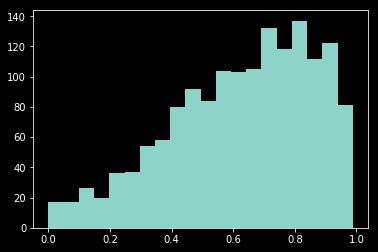

In [33]:
plt.hist(df['X_last_sig_frac'], bins=20)
#plt.show()

In [3]:
outcome_def = 'Y_peak_time_frac_diff'
df[outcome_def] = df['Y_peak_time_frac'] - df['X_peak_time_frac']
#df = df[df['X_sig_exist'] == True]
out_dir = f'results/regression/{outcome_def}'
os.makedirs(out_dir, exist_ok=True)
feat_names = data_tracks.get_feature_names(df)
feat_names = [x for x in feat_names 
              if not x.startswith('sc_') 
              and not x.startswith('nmf_')
              and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max',
                           'X_max_around_Y_peak', 'X_max_after_Y_peak', 'X_max_diff']
              and not x.startswith('pc_')
#               and not 'slope' in x
             ]
#feat_names = ['X_peak_time_frac']

In [4]:
for model_type in tqdm(['rf', 'svm', 'linear', 'gb']):
    out_name = f'{model_type}'
                    #print(out_name)
    train_reg.train_reg(df, feat_names=feat_names[1:15] + feat_names[31:], model_type=model_type, 
                 outcome_def=outcome_def,
                 out_name=f'{out_dir}/{out_name}.pkl') 

 25%|██▌       | 1/4 [00:07<00:23,  7.77s/it]

[0.276875808403219, 0.26803793242113294, 0.35490767607204876, 0.28109289975326, 0.2664427820798958]


 50%|█████     | 2/4 [00:08<00:11,  5.70s/it]

[0.11516289148205139, 0.15009029229998938, 0.15315750669048733, 0.13247245903354554, 0.15295366291211365]
[0.27049141241043906, 0.2521477299018967, 0.3131893343915746, 0.3219146592738401, 0.3439192896976614]


100%|██████████| 4/4 [00:09<00:00,  4.17s/it]

[0.26043375709715444, 0.20543081788032422, 0.32398032509237007, 0.3060839212546601, 0.27380301295840326]


In [5]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r = r.sort_values(by=['r2'], ascending=False)
# r.style.background_gradient(cmap='viridis', axis=None) # all values on same cmap
r

,cv_accuracy_by_cell,r2
model_type,,
linear,"[0.27049141241043906, 0.2521477299018967, 0.31...",0.302
rf,"[0.276875808403219, 0.26803793242113294, 0.354...",0.285
gb,"[0.26043375709715444, 0.20543081788032422, 0.3...",0.273
svm,"[0.11516289148205139, 0.15009029229998938, 0.1...",0.140
dt,"[-0.3754075984574454, -0.8550746872676571, -0....",-0.490
mlp2,"[-2896.828116664122, -93273.4952796763, -45862...",-33651.147
